### Importing Relevant Packages

In [4]:
# General Imports
import tensorflow as tf
import pandas as pd
import numpy as np
import random
import os

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Building Model
from keras.utils import plot_model
from tensorflow.keras import models
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.optimizers import legacy

# Training Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import ModelCheckpoint

# Data Processing
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.preprocessing.image import load_img

In [5]:
# Global variables
SAVE = False
SEED = 111

# Setting seed for consistent results

# Sets the seed for TensorFlow's random number generation. It is used in neural network initialization and training to ensure consistent results across runs.
tf.random.set_seed(SEED)
# Sets the seed for NumPy's random number generator, affecting functions that generate random numbers in NumPy.
np.random.seed(SEED)
# Ensures that Python hash-based operations are repeatable across runs.
os.environ['PYTHONHASHSEED'] = str(SEED)
# Sets the seed for the built-in Python random module, which affects random number generation with this module.
random.seed(SEED)

# Data Visualization updates
%config InlineBackend.figure_format = 'retina'
plt.rcParams["figure.figsize"] = (15, 10)
plt.rcParams.update({'font.size': 14})

### Importing data - Setting up Paths for testing and training data

In [1]:
import os

def load_data(directory, valid_extensions=('jpg', 'jpeg', 'png'), shuffle=True, random_state=0):
    from sklearn.utils import shuffle
    import os

    # Lists to store data and labels
    data_path = []
    data_labels = []
    
    for label in os.listdir(directory):
        label_dir = os.path.join(directory, label)
        if os.path.isdir(label_dir):  # Ensure it's a directory
            # Going into each folder and getting image path
            for image in os.listdir(label_dir):
                if image.lower().endswith(valid_extensions):
                    image_path = os.path.join(label_dir, image)
                    data_path.append(image_path)
                    data_labels.append(label)

    # Shuffle the data after loading   
    if shuffle:
        data_path, data_labels = shuffle(data_path, data_labels, random_state=random_state)
    return data_path, data_labels

# Now load the data
USER_PATH = "D:\\Implementation\\dataMRI"
no_tumor = USER_PATH
tumor = USER_PATH + '\\Tumor'

# Loading data paths and labels in order without shuffling
no_tumor_paths, no_tumor_labels = load_data(no_tumor, shuffle=False)
tumor_paths, tumor_labels = load_data(tumor, shuffle=False)

# Printing No tumor and tumor sample sizes.
print('Normal Brain Scans')
print(f'Number of Paths: {len(no_tumor_paths)}')
print(f'Number of Labels: {len(no_tumor_labels)}')
print('\nTumor Brain Scans')
print(f'Number of Paths: {len(tumor_paths)}')
print(f'Number of Labels: {len(tumor_labels)}')


Normal Brain Scans
Number of Paths: 3066
Number of Labels: 3066

Tumor Brain Scans
Number of Paths: 18606
Number of Labels: 18606



### Splitting Dataset for Training and Testing

In [7]:
from sklearn.model_selection import train_test_split

# Merging paths and labels (to have a single dataset)
MRI_paths = no_tumor_paths + tumor_paths
MRI_labels = no_tumor_labels + tumor_labels

# Split the data into training and testing sets
train_paths, test_paths, train_labels, test_labels = train_test_split ( MRI_paths, MRI_labels, test_size = 0.35, random_state = SEED )

# Create DataFrames for training and testing data
training_images = pd.DataFrame({'path': train_paths, 'label': train_labels})
testing_images = pd.DataFrame({'path': test_paths, 'label': test_labels})


In [8]:
training_images = training_images[training_images['label'] != 'Tumor']
testing_images = testing_images[testing_images['label'] != 'Tumor']

In [9]:
# Identifying distinct tumor categories from the training dataset's labels
Tumor_categories = testing_images['label'].unique()
Category_count =Tumor_categories.size

print(f'Tumor Categories: {Tumor_categories} ')
print(f'Number of Categories : {Category_count}')


Tumor Categories: ['Pituitary' 'Glioma' 'Meningioma' 'NoTumor'] 
Number of Categories : 4


### Convert images to RGB format for Better XAI Explanation

In [10]:
import os
from keras.preprocessing.image import load_img, img_to_array

# Paths to the tumor and non-tumor directories
base_dir = "D:\\Implementation\\dataMRI"
no_tumor_dir = os.path.join(base_dir, "NoTumor")
tumor_dirs = [os.path.join(base_dir, "Tumor", subtype) for subtype in ["Glioma", "Meningioma", "Pituitary"]]

# Function to fetch image paths
def fetch_image_paths(directory):
    image_paths = []
    for root, _, filenames in os.walk(directory):
        for filename in filenames:
            if filename.lower().endswith(('.jpg', '.jpeg', '.png')):
                image_paths.append(os.path.join(root, filename))
    return image_paths

# Generating image paths
non_tumor_image_paths = fetch_image_paths(no_tumor_dir)
tumor_image_paths = []
for tumor_dir in tumor_dirs:
    tumor_image_paths += fetch_image_paths(tumor_dir)

print(f'Found {len(tumor_image_paths)} tumor images and {len(non_tumor_image_paths)} non-tumor images.')

# Function to load and convert an image to RGB
def load_and_convert_to_rgb(image_path, target_size=(240, 240)):
    img = load_img(image_path, target_size=target_size, color_mode='rgb')
    img_array = img_to_array(img) # convert loaded image to a NumPy array
    return img_array

# Process a single image to demonstrate
if tumor_image_paths:  # Check if the list is not empty
    first_tumor_img_array = load_and_convert_to_rgb(tumor_image_paths[0])
    print(first_tumor_img_array.shape)  # Expected to print: (150, 150, 3)
else:
    print("No tumor images found.")


Found 18606 tumor images and 3066 non-tumor images.
(240, 240, 3)


In [11]:
# Mapping dictionary
tumor_classes = {'NoTumor': 0, 'Glioma': 1, 'Meningioma': 2, 'Pituitary': 3 }

# Apply mapping to both DataFrames
training_images['label_encoded'] = training_images['label'].map(tumor_classes)
testing_images['label_encoded'] = testing_images['label'].map(tumor_classes)

print("Training Set:")
display(training_images)

print("\nTesting Set:")
display(testing_images)

Training Set:


path       label  \
0         D:\Implementation\dataMRI\NoTumor\N_60_DA_.jpg     NoTumor   
1      D:\Implementation\dataMRI\Tumor\Meningioma\M_7...  Meningioma   
2      D:\Implementation\dataMRI\Tumor\Meningioma\M_8...  Meningioma   
3      D:\Implementation\dataMRI\Tumor\Glioma\G_112_B...      Glioma   
4       D:\Implementation\dataMRI\Tumor\Glioma\G_576.jpg      Glioma   
...                                                  ...         ...   
14083  D:\Implementation\dataMRI\Tumor\Pituitary\P_30...   Pituitary   
14084  D:\Implementation\dataMRI\Tumor\Meningioma\M_1...  Meningioma   
14085  D:\Implementation\dataMRI\Tumor\Pituitary\P_28...   Pituitary   
14086  D:\Implementation\dataMRI\Tumor\Pituitary\P_71...   Pituitary   
14087  D:\Implementation\dataMRI\Tumor\Meningioma\M_8...  Meningioma   

       label_encoded  
0                  0  
1                  2  
2                  2  
3                  1  
4                  1  
...              ...  
14083              3  
14084              2  
14085              3  
14086              3  
14087              2  

[14086 rows x 3 columns]


Testing Set:


path       label  \
0     D:\Implementation\dataMRI\Tumor\Pituitary\P_54...   Pituitary   
1      D:\Implementation\dataMRI\Tumor\Glioma\G_871.jpg      Glioma   
2     D:\Implementation\dataMRI\Tumor\Meningioma\M_7...  Meningioma   
3     D:\Implementation\dataMRI\Tumor\Pituitary\P_66...   Pituitary   
4     D:\Implementation\dataMRI\Tumor\Pituitary\P_20...   Pituitary   
...                                                 ...         ...   
7582  D:\Implementation\dataMRI\Tumor\Glioma\G_546_S...      Glioma   
7583  D:\Implementation\dataMRI\Tumor\Meningioma\M_4...  Meningioma   
7584    D:\Implementation\dataMRI\NoTumor\N_176_DA_.jpg     NoTumor   
7585  D:\Implementation\dataMRI\Tumor\Pituitary\P_16...   Pituitary   
7586  D:\Implementation\dataMRI\Tumor\Glioma\G_390_B...      Glioma   

      label_encoded  
0                 3  
1                 1  
2                 2  
3                 3  
4                 3  
...             ...  
7582              1  
7583              2  
7584              0  
7585              3  
7586              1  

[7586 rows x 3 columns]

### Pre-Processing Images

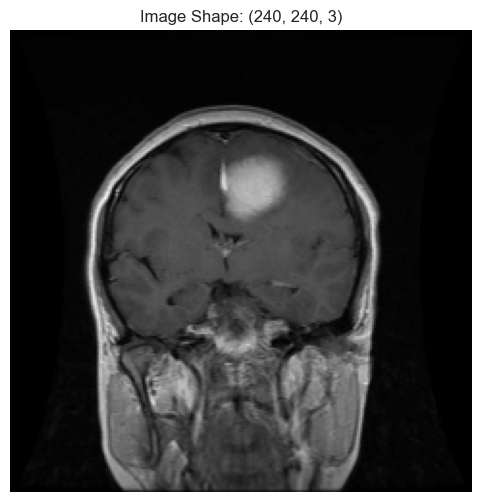

Images batch shape:  (1, 240, 240, 3)


In [3]:
def img_preprocessing(image_path, target_size=(240, 240), visualize=False):
    # Read and decode the image in RGB
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)  # Ensures image is decoded in RGB format
    
    # Resize and normalize the image
    img = tf.image.resize(img, target_size)
    img = img / 255.0  # Normalize the pixel values to be between 0 and 1

    if visualize:
        plt.figure(figsize=(6, 6))  # setup figure
        plt.imshow(img) # Display the image
        plt.title(f"Image Shape: {img.shape}")  # Display the shape of the image with the title
        plt.axis('off')  # Hide the axis
        plt.show() #shows the plot
    return img

image_path = "E:/m20.jpg"
preprocessed_img = img_preprocessing(image_path, visualize=True)

# image_paths = ["E:/m20.jpg"]  # To have multiple images, add more paths to the list

# Creating the dataset
dataset = tf.data.Dataset.from_tensor_slices(image_paths) # Creates a tensorflow dataset.
dataset = dataset.map(img_preprocessing).batch(1)  # Using a batch size of 1 for simplicity

# Iterate through the dataset and output shapes and labels for confirmation
for images in dataset:
    print("Images batch shape: ", images.shape)


In [ ]:
batch_size = 32

# Creating dataset loaders with label indices for training
train_loader = tf.data.Dataset.from_tensor_slices((training_images['path'], training_images['label_encoded']))
train_dataset = train_loader.map(img_preprocessing).batch(batch_size).shuffle(buffer_size=len(training_images)).prefetch(tf.data.AUTOTUNE)

# Creating dataset loaders with label indices for testing
test_loader = tf.data.Dataset.from_tensor_slices((testing_images['path'], testing_images['label_encoded']))
test_dataset = test_loader.map(img_preprocessing).batch(batch_size).shuffle(buffer_size=len(testing_images)).prefetch(tf.data.AUTOTUNE)

### CNN Model Architecture

In [16]:
import tensorflow as tf
import numpy as np
import os
from tensorflow.keras import models
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

N_TYPES = 4  # Number of classes
batch_size = 150

# Image shape for RGB images
image_size = (240, 240)
image_shape = (image_size[0], image_size[1], 3)  # Updated for RGB images

# Model Architecture
model = models.Sequential([
    
    # Extracting initial features from the images
    Conv2D(32, (4, 4), activation="relu", input_shape=image_shape, name='conv2d_layer1'),
    # Reducing the dimensions of the output from the convolutional layer.
    MaxPooling2D(pool_size=(3, 3), name='maxpooling_layer1'),
    
    Conv2D(64, (3, 3), activation="relu", name='conv2d_layer2'),
    MaxPooling2D(pool_size=(3, 3), name='maxpooling_layer2'),
    
    Conv2D(128, (3, 3), activation="relu", name='conv2d_layer3'),
    MaxPooling2D(pool_size=(3, 3), name='maxpooling_layer3'),
    
    Conv2D(256, (3, 3), activation="relu", name='conv2d_layer4'),
    Flatten(name='flatten_layer'), # Flattening the feature maps into a one dimensional vector.
    
    # Learning non-linear combinations of the high-level features represented by the convolutional layers.
    Dense(512, activation="relu", name='dense_layer1'),
    # Regularization technique to prevent overfitting
    Dropout(0.5, seed=SEED, name='dropout_layer'),
    # Outputs the probabilities of the image belonging to each class
    Dense(N_TYPES, activation="softmax", name='output_layer')
    
], name='Brain_Scan_CNN_Model')

#Printing the model summary
model.summary()

# Compile the Model
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Define Callbacks
callbacks = [
    # Stop training when a monitored quantity has stopped improving.
    EarlyStopping(monitor='loss', patience=10, verbose=1),
    # Reduce learning rate when a metric has stopped improving.
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1),
    # Save the model after every epoch when validation accuracy improves.
    ModelCheckpoint(filepath='tumors.h5', save_best_only=True, monitor='val_accuracy', verbose=1) 
]

Model: "Brain_Scan_CNN_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_layer1 (Conv2D)      (None, 237, 237, 32)      1568      
                                                                 
 maxpooling_layer1 (MaxPool  (None, 79, 79, 32)        0         
 ing2D)                                                          
                                                                 
 conv2d_layer2 (Conv2D)      (None, 77, 77, 64)        18496     
                                                                 
 maxpooling_layer2 (MaxPool  (None, 25, 25, 64)        0         
 ing2D)                                                          
                                                                 
 conv2d_layer3 (Conv2D)      (None, 23, 23, 128)       73856     
                                                                 
 maxpooling_layer3 (MaxPool  (None, 7, 7, 128)

### Training the Model

In [85]:
history = model.fit(train_dataset,
                    epochs=25,
                    batch_size=150,
                    validation_data=test_dataset,
                    callbacks=callbacks)


Epoch 1/25
94/94 [==============================] - ETA: 0s - loss: 1.0199 - accuracy: 0.5532

D:\Implementation\FYPImplementation\.venv\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


94/94 [==============================] - 333s 3s/step - loss: 1.0199 - accuracy: 0.5532 - val_loss: 0.7663 - val_accuracy: 0.6988 - lr: 0.0010
Epoch 2/25
94/94 [==============================] - 371s 3s/step - loss: 0.6563 - accuracy: 0.7409 - val_loss: 0.5081 - val_accuracy: 0.8023 - lr: 0.0010
Epoch 3/25
94/94 [==============================] - 416s 3s/step - loss: 0.4159 - accuracy: 0.8457 - val_loss: 0.3097 - val_accuracy: 0.8865 - lr: 0.0010
Epoch 4/25
94/94 [==============================] - 383s 3s/step - loss: 0.2812 - accuracy: 0.8965 - val_loss: 0.2417 - val_accuracy: 0.9118 - lr: 0.0010
Epoch 5/25
94/94 [==============================] - 350s 3s/step - loss: 0.1814 - accuracy: 0.9336 - val_loss: 0.1874 - val_accuracy: 0.9400 - lr: 0.0010
Epoch 6/25
94/94 [==============================] - 339s 3s/step - loss: 0.1404 - accuracy: 0.9505 - val_loss: 0.1782 - val_accuracy: 0.9425 - lr: 0.0010
Epoch 7/25
94/94 [==============================] - 354s 3s/step - loss: 0.0930 - accur

In [86]:
from tensorflow.keras.models import load_model
model = load_model('Tumors.h5')

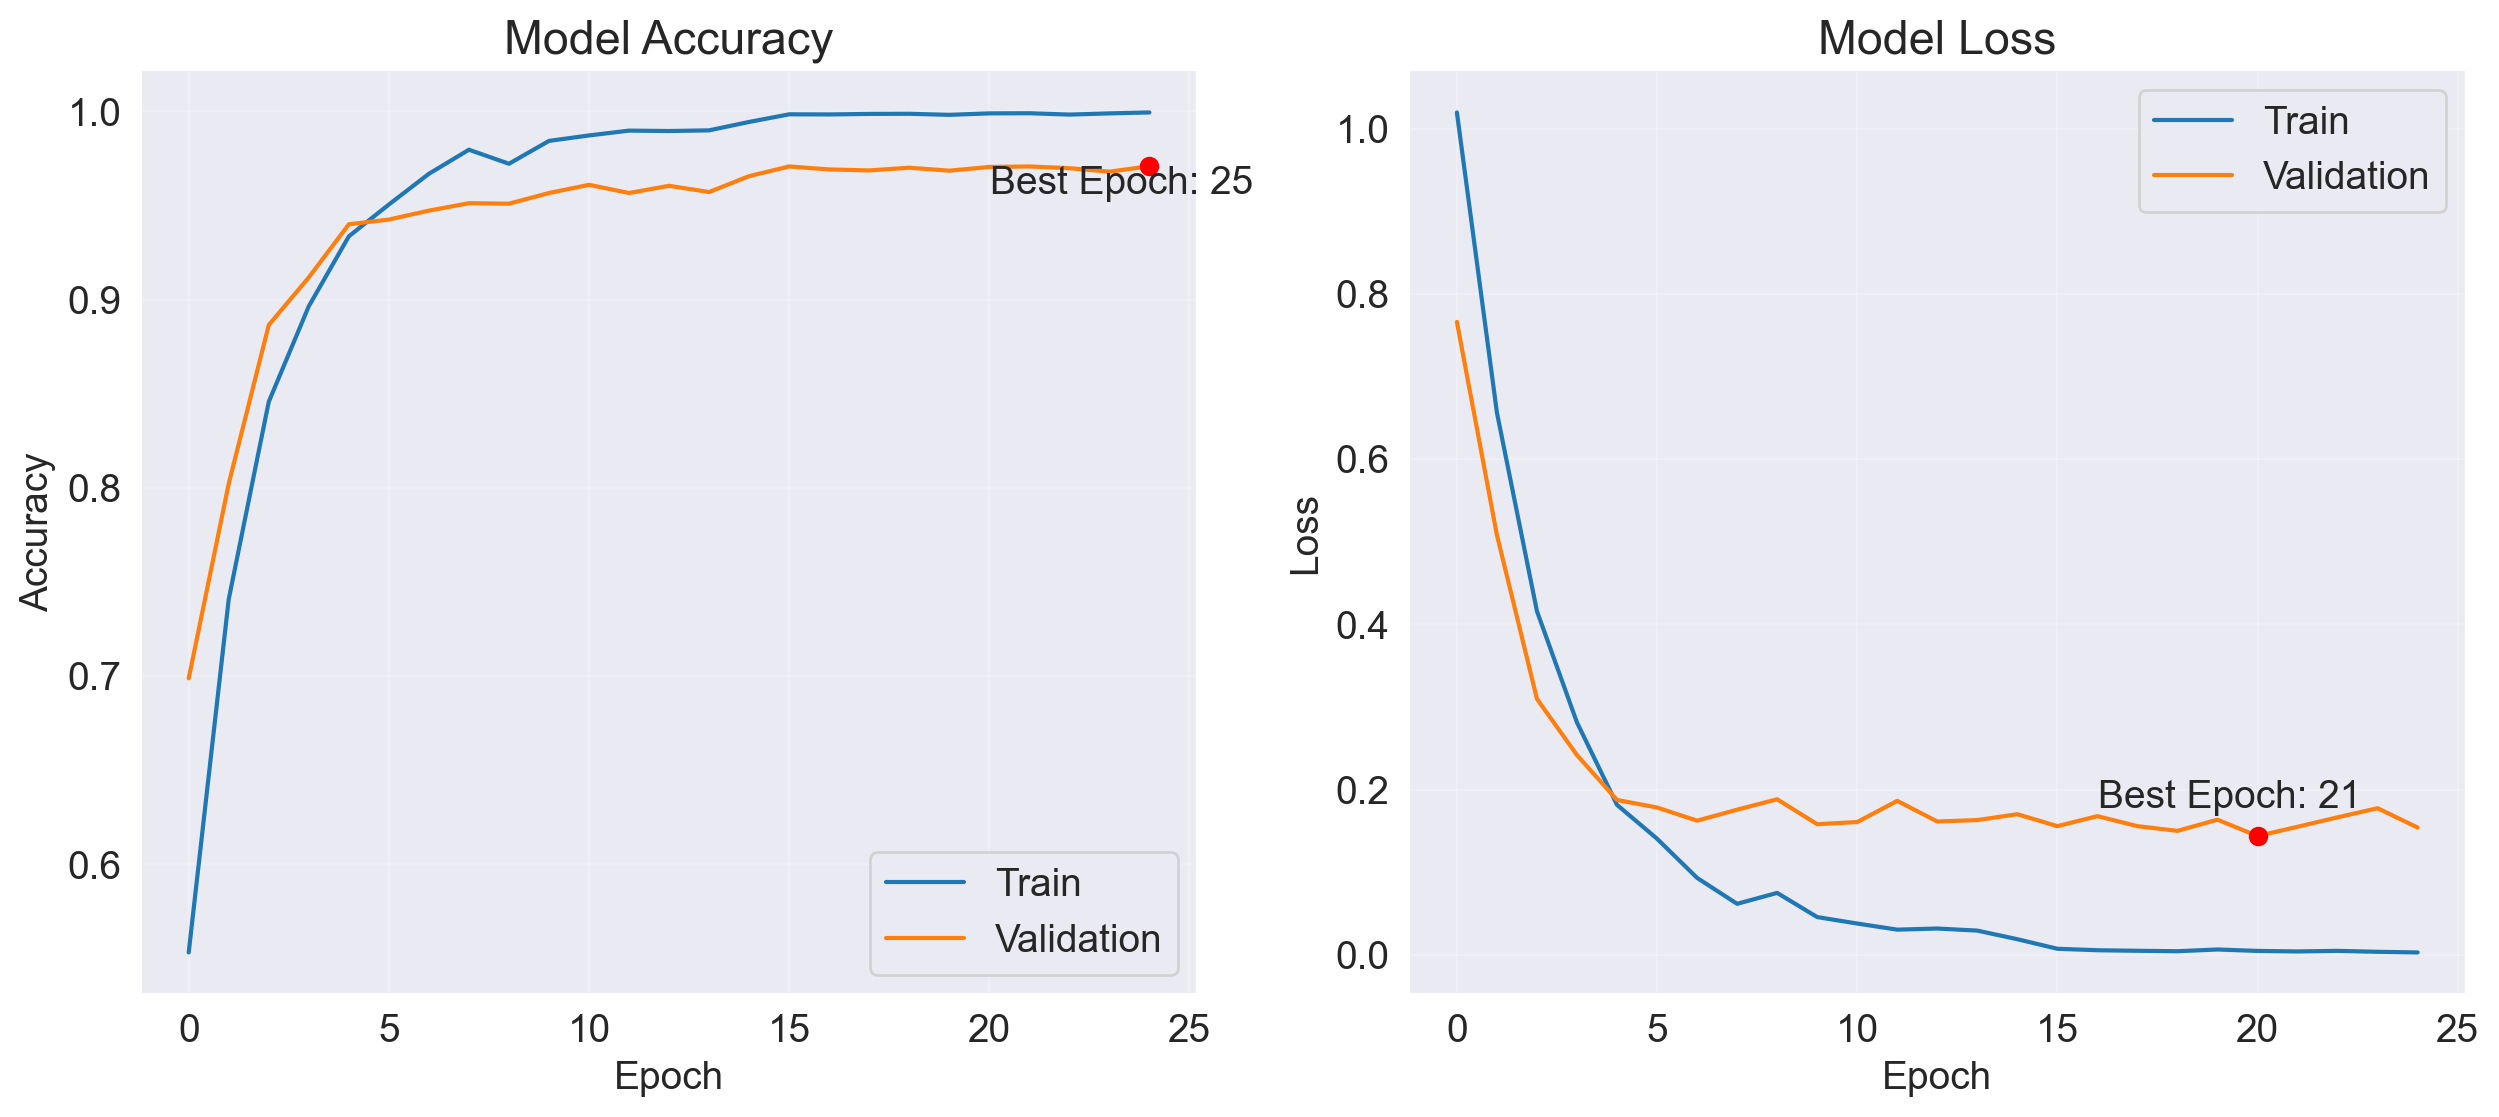

In [87]:
_, ax = plt.subplots(ncols=2, figsize=(15, 6))

# Training and Validation Accuracy
ax[0].plot(history.history['accuracy'], label='Train')
ax[0].plot(history.history['val_accuracy'], label='Validation')
ax[0].set_title('Model Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Accuracy')

# Highlight the best epoch
best_epoch_acc = np.argmax(history.history['val_accuracy'])
best_val_acc = np.max(history.history['val_accuracy'])
ax[0].plot(best_epoch_acc, best_val_acc, 'ro')  # 'ro' for red circle
ax[0].annotate(f"Best Epoch: {best_epoch_acc+1}", (best_epoch_acc, best_val_acc), textcoords="offset points", xytext=(-10,-10), ha='center')
ax[0].legend()
ax[0].grid(alpha=0.2)

# Training and Validation Loss
ax[1].plot(history.history['loss'], label='Train')
ax[1].plot(history.history['val_loss'], label='Validation')
ax[1].set_title('Model Loss')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')

# Highlight the best epoch for loss
best_epoch_loss = np.argmin(history.history['val_loss'])
best_val_loss = np.min(history.history['val_loss'])
ax[1].plot(best_epoch_loss, best_val_loss, 'ro')  # 'ro' for red circle
ax[1].annotate(f"Best Epoch: {best_epoch_loss+1}", (best_epoch_loss, best_val_loss), textcoords="offset points", xytext=(-10,10), ha='center')
ax[1].legend()
ax[1].grid(alpha=0.2)

plt.show()


5/5 [==============================] - 0s 65ms/step
Classification Report:
               precision    recall  f1-score   support

     NoTumor       0.97      0.97      0.97      1063
      Glioma       0.96      0.96      0.96      2248
  Meningioma       0.96      0.96      0.96      2219
   Pituitary       0.99      0.99      0.99      2056

    accuracy                           0.97      7586
   macro avg       0.97      0.97      0.97      7586
weighted avg       0.97      0.97      0.97      7586


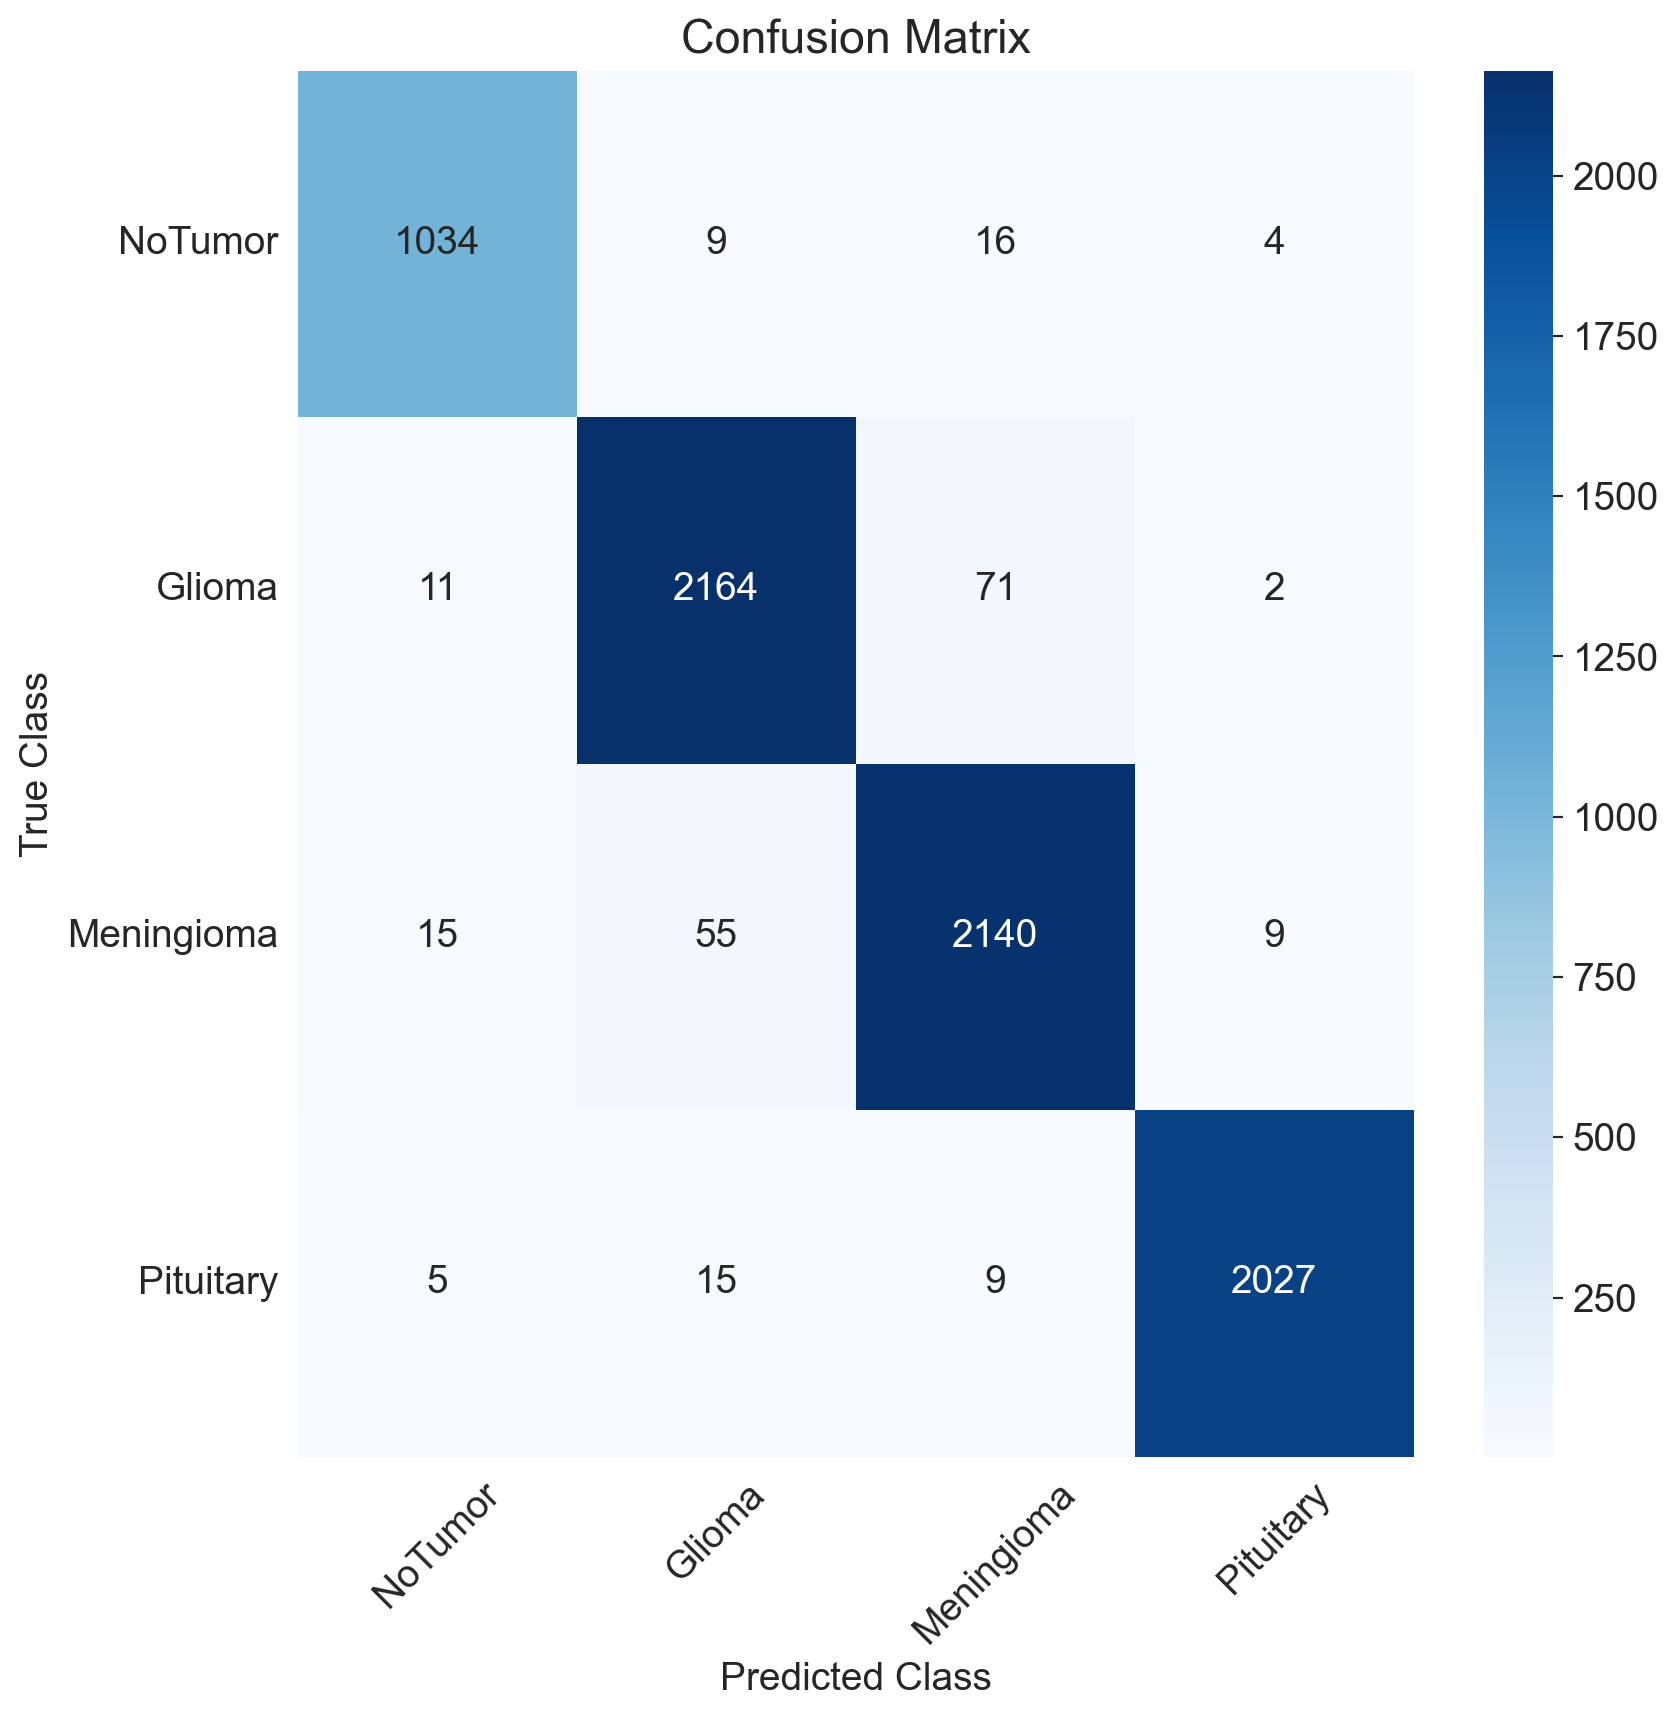

In [88]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

def plot_confusion_matrix(cm, class_names):
    plt.figure(figsize=(9, 9))
    sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', cbar=True)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Class")
    plt.ylabel("True Class")
    plt.xticks(np.arange(len(class_names)) + 0.5, class_names, rotation=45)
    plt.yticks(np.arange(len(class_names)) + 0.5, class_names, rotation=0)
    plt.show()

def generate_confusion_matrix(model, test_dataset, class_names):
    true_labels = []
    predicted_labels = []

    for batch in test_dataset:
        images, labels = batch
        predictions = model.predict(images)
        predicted_classes = np.argmax(predictions, axis=1)
        true_classes = np.argmax(labels, axis=1)

        true_labels.extend(true_classes)
        predicted_labels.extend(predicted_classes)

    cm = confusion_matrix(true_labels, predicted_labels)
    print("Classification Report:\n", classification_report(true_labels, predicted_labels, target_names=class_names))

    return cm

# Define class names based on your model's training labels
class_names = ['NoTumor', 'Glioma', 'Meningioma', 'Pituitary']

# Usage example
# Assume `model`, `test_dataset`, and `class_names` are already defined
cm = generate_confusion_matrix(model, test_dataset, class_names)
plot_confusion_matrix(cm, class_names)


In [21]:
from tensorflow.keras.models import load_model

# Load the trained model from file
model = load_model('tumors.h5')


In [2]:
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import load_model
from sklearn.metrics import accuracy_score
import pandas as pd
from sklearn.model_selection import train_test_split

# Tumor classes mapping as described
tumor_classes = {'NoTumor': 0, 'Glioma': 1, 'Meningioma': 2, 'Pituitary': 3}

# Function to prepare images from paths
def prepare_images(paths, target_size=(240, 240)):
    images = []
    for img_path in paths:
        img = load_img(img_path, target_size=target_size)
        img = img_to_array(img)
        img /= 255.0  # Normalize to [0, 1]
        images.append(img)
    return np.array(images)

# Preparing test images and labels
test_images = prepare_images(testing_images['path'])

model = load_model('tumors.h5')

# Make predictions on the test images
predictions = model.predict(test_images)

# Convert predictions to class indices
predicted_classes = np.argmax(predictions, axis=1)

# Extract true labels from the test DataFrame (already encoded using your mapping)
true_labels = testing_images['label'].map(tumor_classes).values

# Calculate accuracy
accuracy = accuracy_score(true_labels, predicted_classes)
print(f"Model accuracy on the test dataset: {accuracy:.2%}")


NameError: name 'testing_images' is not defined

***ROC-AUC Curve***

In [43]:
from tensorflow.keras.models import load_model
model = load_model('Tumors.h5')

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_curve, auc
from tensorflow.keras.utils import to_categorical

def prepare_dataset(dataset):
    images = []
    labels = []
    for img, label in dataset:
        img = img.numpy() / 255.0
        images.append(img)
        if isinstance(label, tf.Tensor):
            label = label.numpy()
        labels.append(label)
    return np.array(images), np.array(labels)

test_images, test_labels = prepare_dataset(test_dataset)

if test_labels.ndim > 1:
    # Convert one-hot encoded labels to scalars
    test_labels_scalar = np.argmax(test_labels, axis=1)
else:
    test_labels_scalar = test_labels

label_encoder = LabelEncoder()
test_labels_encoded = label_encoder.fit_transform(test_labels_scalar)
test_labels_one_hot = to_categorical(test_labels_encoded, num_classes=N_TYPES)

predictions = model.predict(test_images)

# Compute ROC curve and ROC AUC for each class
fpr, tpr, roc_auc = {}, {}, {}
for i in range(N_TYPES):
    fpr[i], tpr[i], _ = roc_curve(test_labels_one_hot[:, i], predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plotting the ROC curve for each class
plt.figure(figsize=(12, 8))
colors = ['blue', 'red', 'green', 'cyan']  # Adjust colors as needed
class_names = label_encoder.classes_  # Assuming classes can be directly mapped from the label encoder

for i, color in zip(range(N_TYPES), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'.format(class_names[i] if class_names.dtype == object else i, roc_auc[i]))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) - Multi-Class')
plt.legend(loc="lower right")
plt.show()


***Feature Maps***

1/1 [==============================] - 3s 3s/step


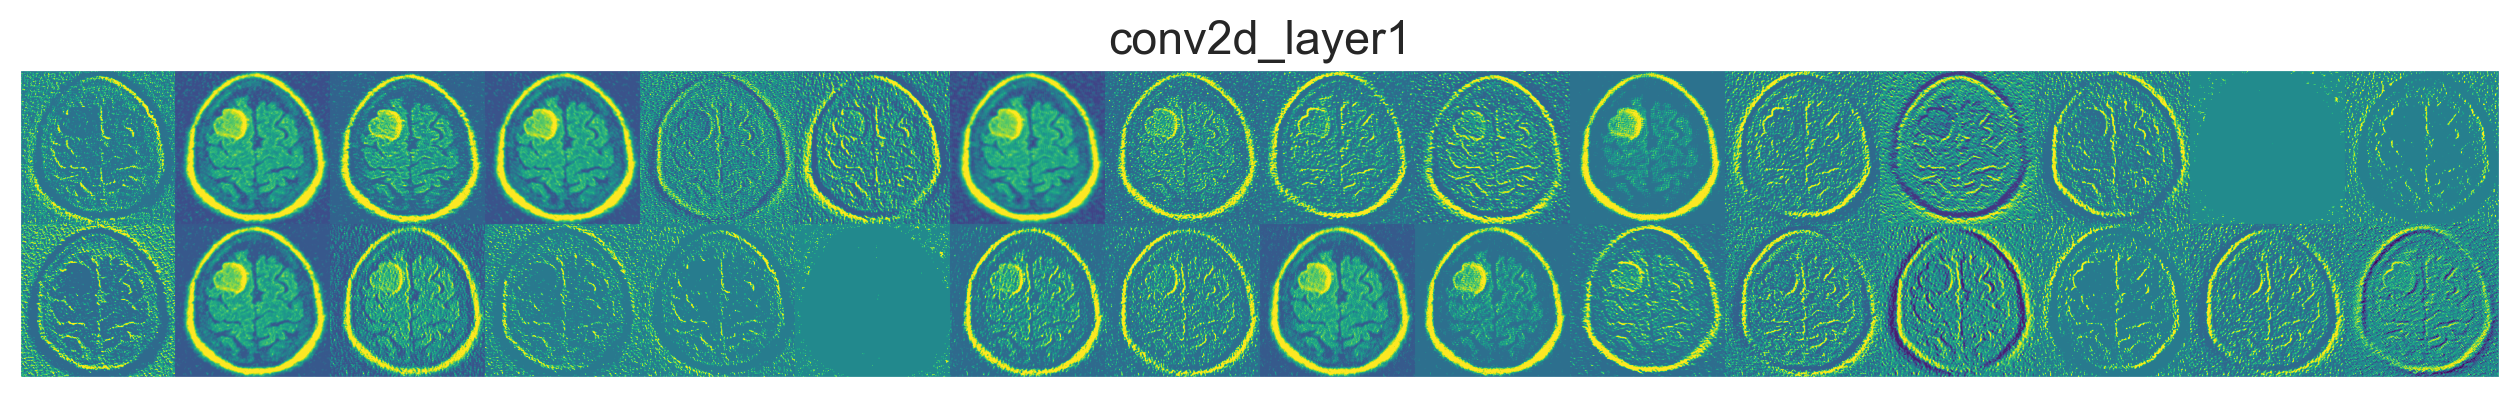

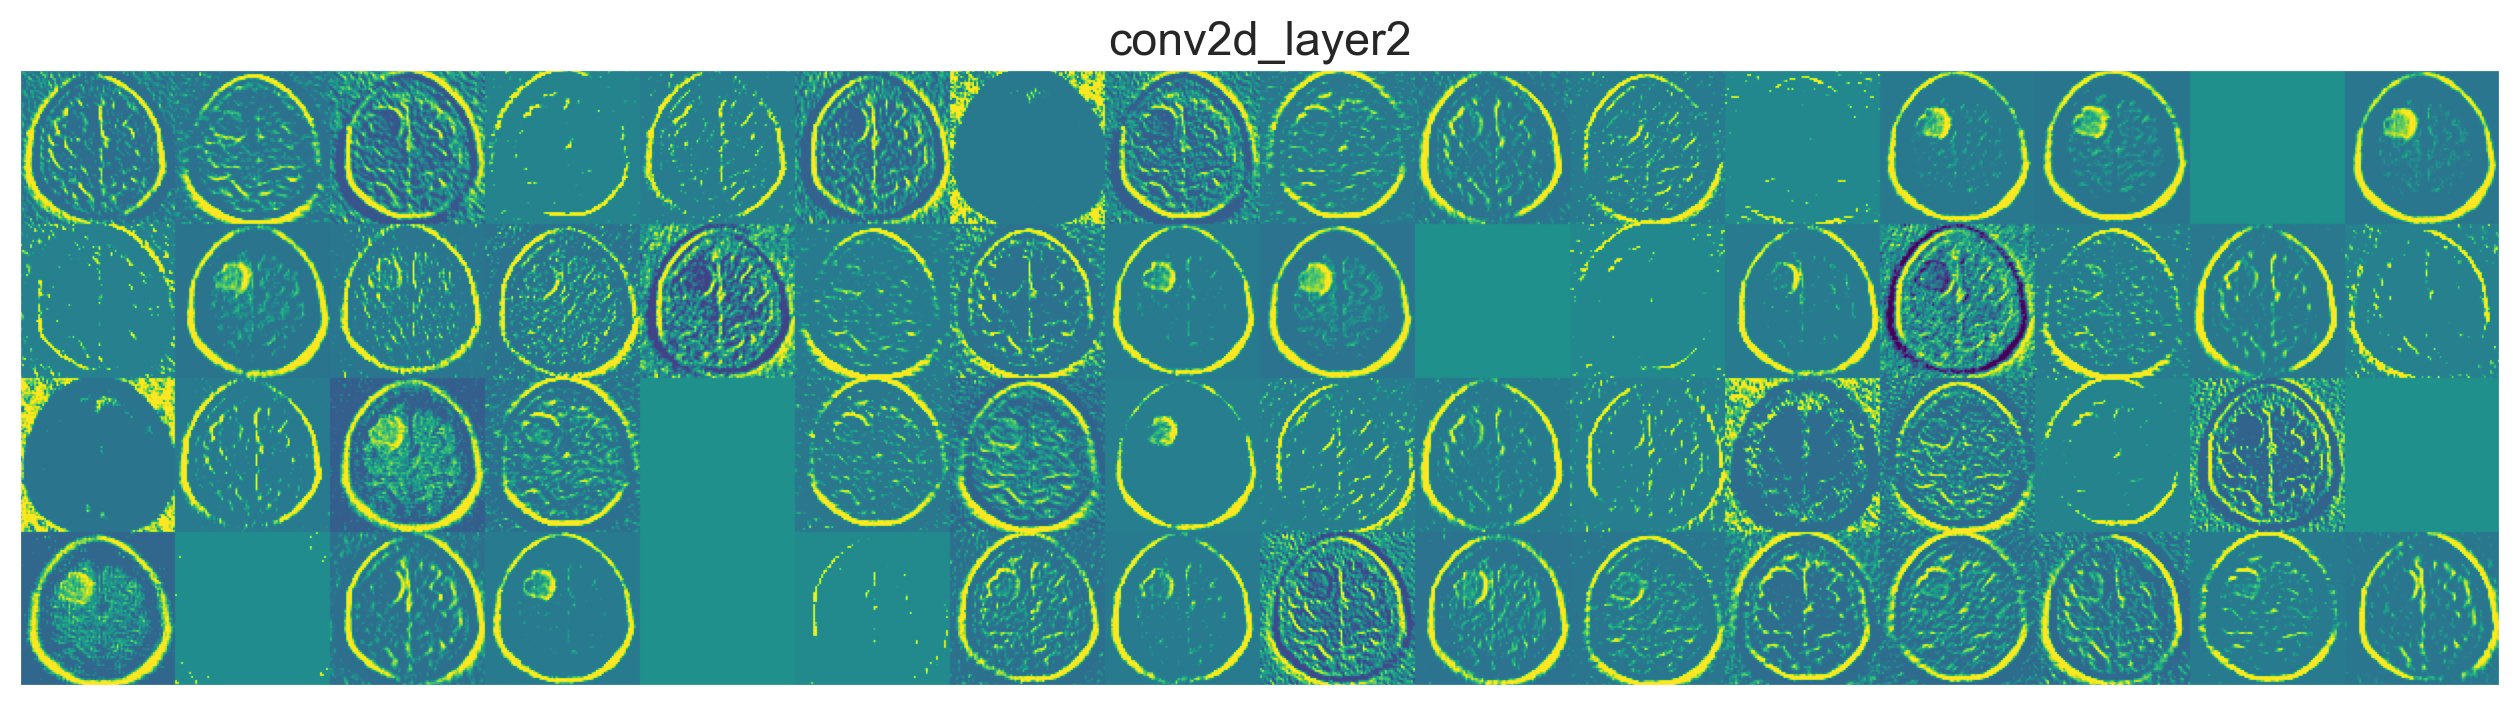

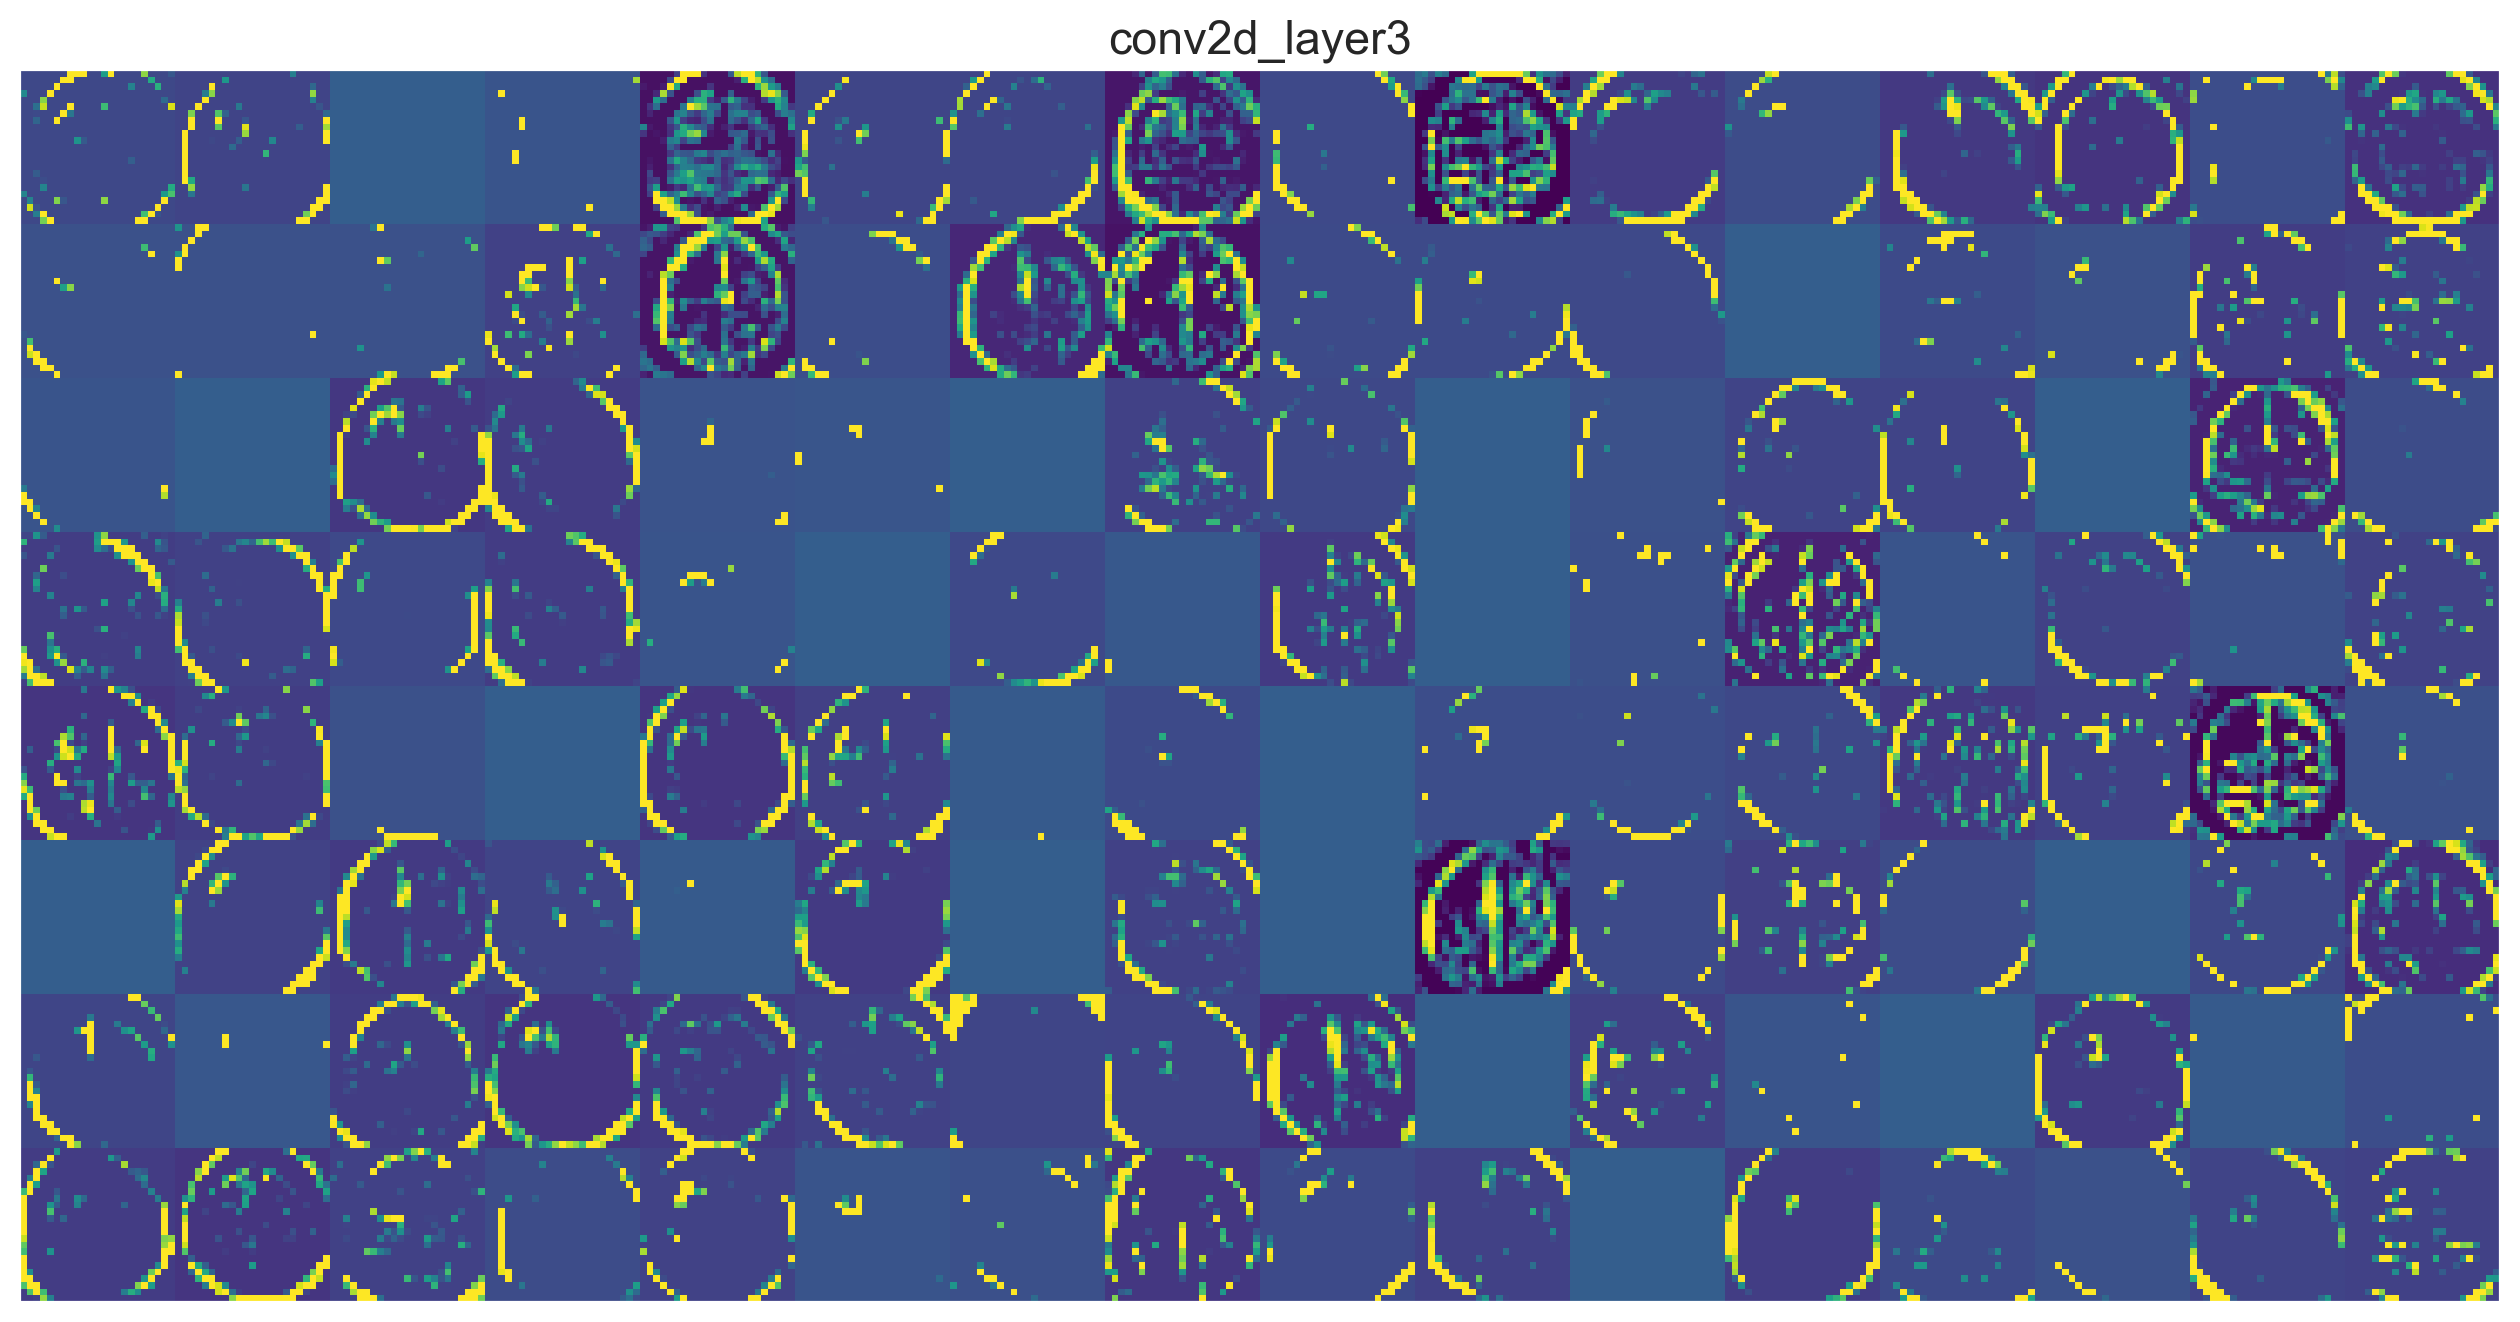

In [45]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Model

def visualize_feature_maps(model, layer_names, image_size=(240, 240)):
    img = load_img(image_path, target_size=image_size)
    img = img_to_array(img)
    img /= 255.0
    img = np.expand_dims(img, axis=0)
    
    layer_outputs = [model.get_layer(name).output for name in layer_names]
    activation_model = Model(inputs=model.input, outputs=layer_outputs)
    
    # Running prediction
    activations = activation_model.predict(img)
    
    for layer_activations, layer_name in zip(activations, layer_names):
        n_features = layer_activations.shape[-1]
        size = layer_activations.shape[1]
        
        # Calculate the number of grids needed for the visualization
        n_cols = n_features // 16 + (n_features % 16 > 0)
        display_grid = np.zeros((size * n_cols, size * 16))
        
        for col in range(n_cols):
            for row in range(16):
                if col * 16 + row < n_features:  # Check if the feature map exists
                    channel_image = layer_activations[0, :, :, col * 16 + row]
                    # Normalize the feature map for better visualization
                    channel_image -= channel_image.mean()
                    channel_std = channel_image.std()
                    if channel_std > 0:
                        channel_image /= channel_std
                    channel_image *= 64
                    channel_image += 128
                    channel_image = np.clip(channel_image, 0, 255).astype('uint8')
                    display_grid[col * size: (col + 1) * size, row * size: (row + 1) * size] = channel_image
        
        scale = 1. / size
        plt.figure(figsize=(scale * display_grid.shape[1], scale * display_grid.shape[0]))
        plt.title(layer_name)
        plt.grid(False)
        plt.imshow(display_grid, aspect='auto', cmap='viridis')
        
        # Remove ticks for better visualization
        plt.xticks([])
        plt.yticks([])
        plt.show()

layer_names = ['conv2d_layer1', 'conv2d_layer2', 'conv2d_layer3'] 

visualize_feature_maps(model, layer_names)


### Trained Model for Tumor Prediction

In [38]:
# Codes for performance evaluation
import psutil  # Python library for retrieving information on running processes and system utilization.

def get_resource_usage():
    cpu_usage = psutil.cpu_percent()
    memory_usage = psutil.virtual_memory().percent
    return cpu_usage, memory_usage


In [39]:
cpu_before, memory_before = get_resource_usage()

In [5]:
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt

def preprocess_image(image_path, target_size=(240, 240)):
    # Load the image file, resizing it to the target size and converting it to RGB
    img = load_img(image_path, target_size=target_size, color_mode="rgb")  # Changed to "RGB"
    img = img_to_array(img)
    img /= 255.0  # Normalize the image
    img = np.expand_dims(img, axis=0)  # Add batch dimension
    return img

model_path = "Tumors.h5"
model = load_model(model_path)

class_names_mapping = {0: 'NoTumor', 1: 'Glioma', 2: 'Meningioma', 3: 'Pituitary'}

def predict_tumor_category(image_path, model):
    img_tensor = preprocess_image(image_path)
    predictions = model.predict(img_tensor)
    # Extracts the index of the class with the highest predicted probability for the images in the batch
    predicted_class_index = np.argmax(predictions, axis=1)[0]
    predicted_class_name = class_names_mapping[predicted_class_index]
    return predicted_class_name

image_path = "E:/m20.jpg"
predicted_class_name = predict_tumor_category(image_path, model)
print(f"Predicted tumor type: {predicted_class_name}")


1/1 [==============================] - 7s 7s/step
Predicted tumor type: Meningioma


### Generating the XAI Explanations

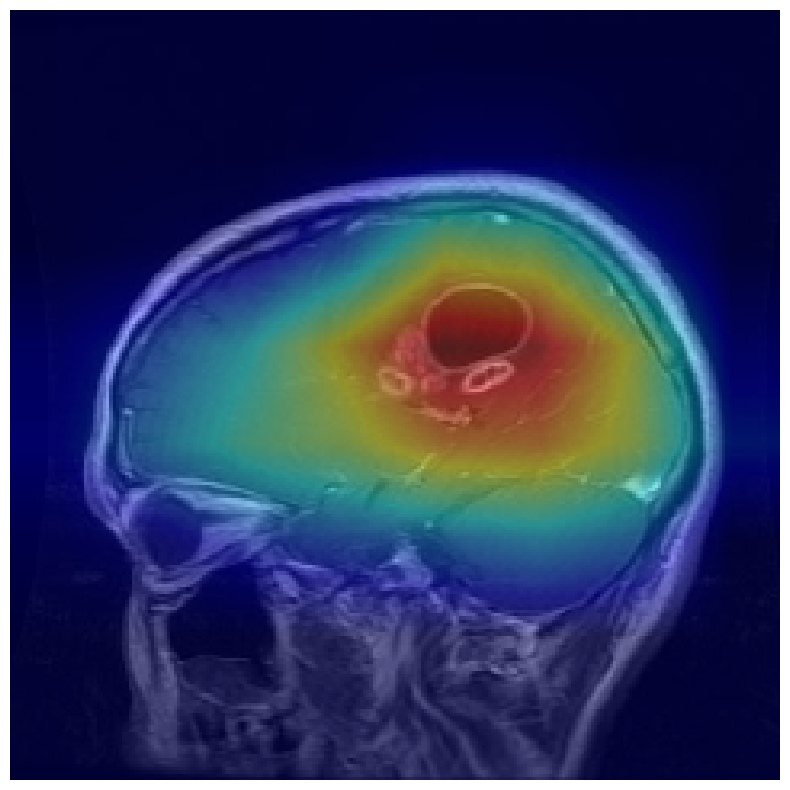

In [49]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import cv2
from tensorflow.keras.models import load_model

def preprocess_image(image_path, target_size=(240, 240)):
    # Load the image file, resizing it to the target size and converting it to RGB
    img = load_img(image_path, target_size=target_size, color_mode="rgb")  # Changed to "rgb"
    img = img_to_array(img)
    img /= 255.0  # Normalize the image
    img = np.expand_dims(img, axis=0)  # Add batch dimension
    return img

# Path to the .h5 file
model_path = 'XAI2.h5'

# Load the trained model
model = load_model(model_path)

img_path = "D:\Implementation\dataMRI\Tumor\Glioma\G_12.jpg" 
img = tf.keras.preprocessing.image.load_img(img_path, target_size=(240, 240))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0) 

def VizGradCAM(model, img_array, last_conv_layer_name):
    img_size = (240, 240)
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        top_pred_index = tf.argmax(preds[0])
        top_class_channel = preds[:, top_pred_index]

    grads = tape.gradient(top_class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    heatmap = heatmap.numpy()
    heatmap = np.max(heatmap) - heatmap
    heatmap = cv2.resize(heatmap, (img_size[1], img_size[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    if img_array.max() > 1:
        img_array = img_array / 255.0
    if img_array.dtype != np.uint8:
        img_array = np.uint8(255 * img_array)

    superimposed_img = cv2.addWeighted(img_array[0], 0.6, heatmap, 0.4, 0)  # colored heatmap superimposed on the original image
    superimposed_img = tf.keras.preprocessing.image.array_to_img(superimposed_img)

    plt.figure(figsize=(10, 10))
    plt.imshow(superimposed_img)
    plt.axis('off')
    plt.show()

last_conv_layer_name = 'top_conv' 
VizGradCAM(model, img_array, last_conv_layer_name)


In [43]:
cpu_after, memory_after = get_resource_usage()

In [46]:
cpu_difference = cpu_after - cpu_before
memory_difference = memory_after - memory_before

print(f"CPU Usage before running the model: {cpu_before}%")
print(f"CPU Usage after running the model: {cpu_after}%")

print(f"\nMemory Usage before running the model: {memory_before}%")
print(f"Memory Usage after running the model: {memory_after}%")

print(f"\nCPU Usage Difference: {cpu_difference}%")
print(f"Memory Usage Difference: {memory_difference}%")


CPU Usage before running the model: 4.3%
CPU Usage after running the model: 16.6%

Memory Usage before running the model: 88.8%
Memory Usage after running the model: 93.1%

CPU Usage Difference: 12.3%
Memory Usage Difference: 4.299999999999997%


In [1]:
from tensorflow.keras.applications import EfficientNetB1
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# Constants
N_TYPES = 4  # Number of classes
batch_size = 32 
SEED = 42  # Assuming you define a seed for reproducibility

# Image size for RGB images
image_size = (240, 240)
image_shape = (image_size[0], image_size[1], 3)

# Load EfficientNetB1 without the top layer and set input shape
base_model = EfficientNetB1(include_top=False, input_shape=image_shape, weights='imagenet')

# Make all layers non-trainable (optional)
for layer in base_model.layers:
    layer.trainable = False

# Adding custom layers
x = base_model.output
x = GlobalAveragePooling2D(name='global_avg_pooling')(x)
x = Dense(512, activation='relu', name='dense_layer1')(x)
x = Dropout(0.5, seed=SEED, name='dropout_layer')(x)
predictions = Dense(N_TYPES, activation='softmax', name='output_layer')(x)

# Final model
model = Model(inputs=base_model.input, outputs=predictions, name='Brain_Scan_CNN_Model_EfficientNet')

# Compile the Model
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Model Summary
model.summary()

# Define Callbacks
callbacks = [
    EarlyStopping(monitor='loss', patience=6, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1),
    ModelCheckpoint(filepath='efficientnet_tumors.h5', save_best_only=True, monitor='val_accuracy', verbose=1)
]


Model: "Brain_Scan_CNN_Model_EfficientNet"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 240, 240, 3)]        0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, 240, 240, 3)          0         ['input_1[0][0]']             
                                                                                                  
 normalization (Normalizati  (None, 240, 240, 3)          7         ['rescaling[0][0]']           
 on)                                                                                              
                                                                                                  
 rescaling_1 (Rescaling)     (None, 240, 240, 3)          0       

### Graphical representation for splitting dataset for Training and Testing categories

Training Counts
{'NoTumor': 2003, 'Meningioma': 4172, 'Glioma': 4059, 'Pituitary': 3852}

Testing Counts
{'NoTumor': 1063, 'Meningioma': 2219, 'Glioma': 2248, 'Pituitary': 2056}


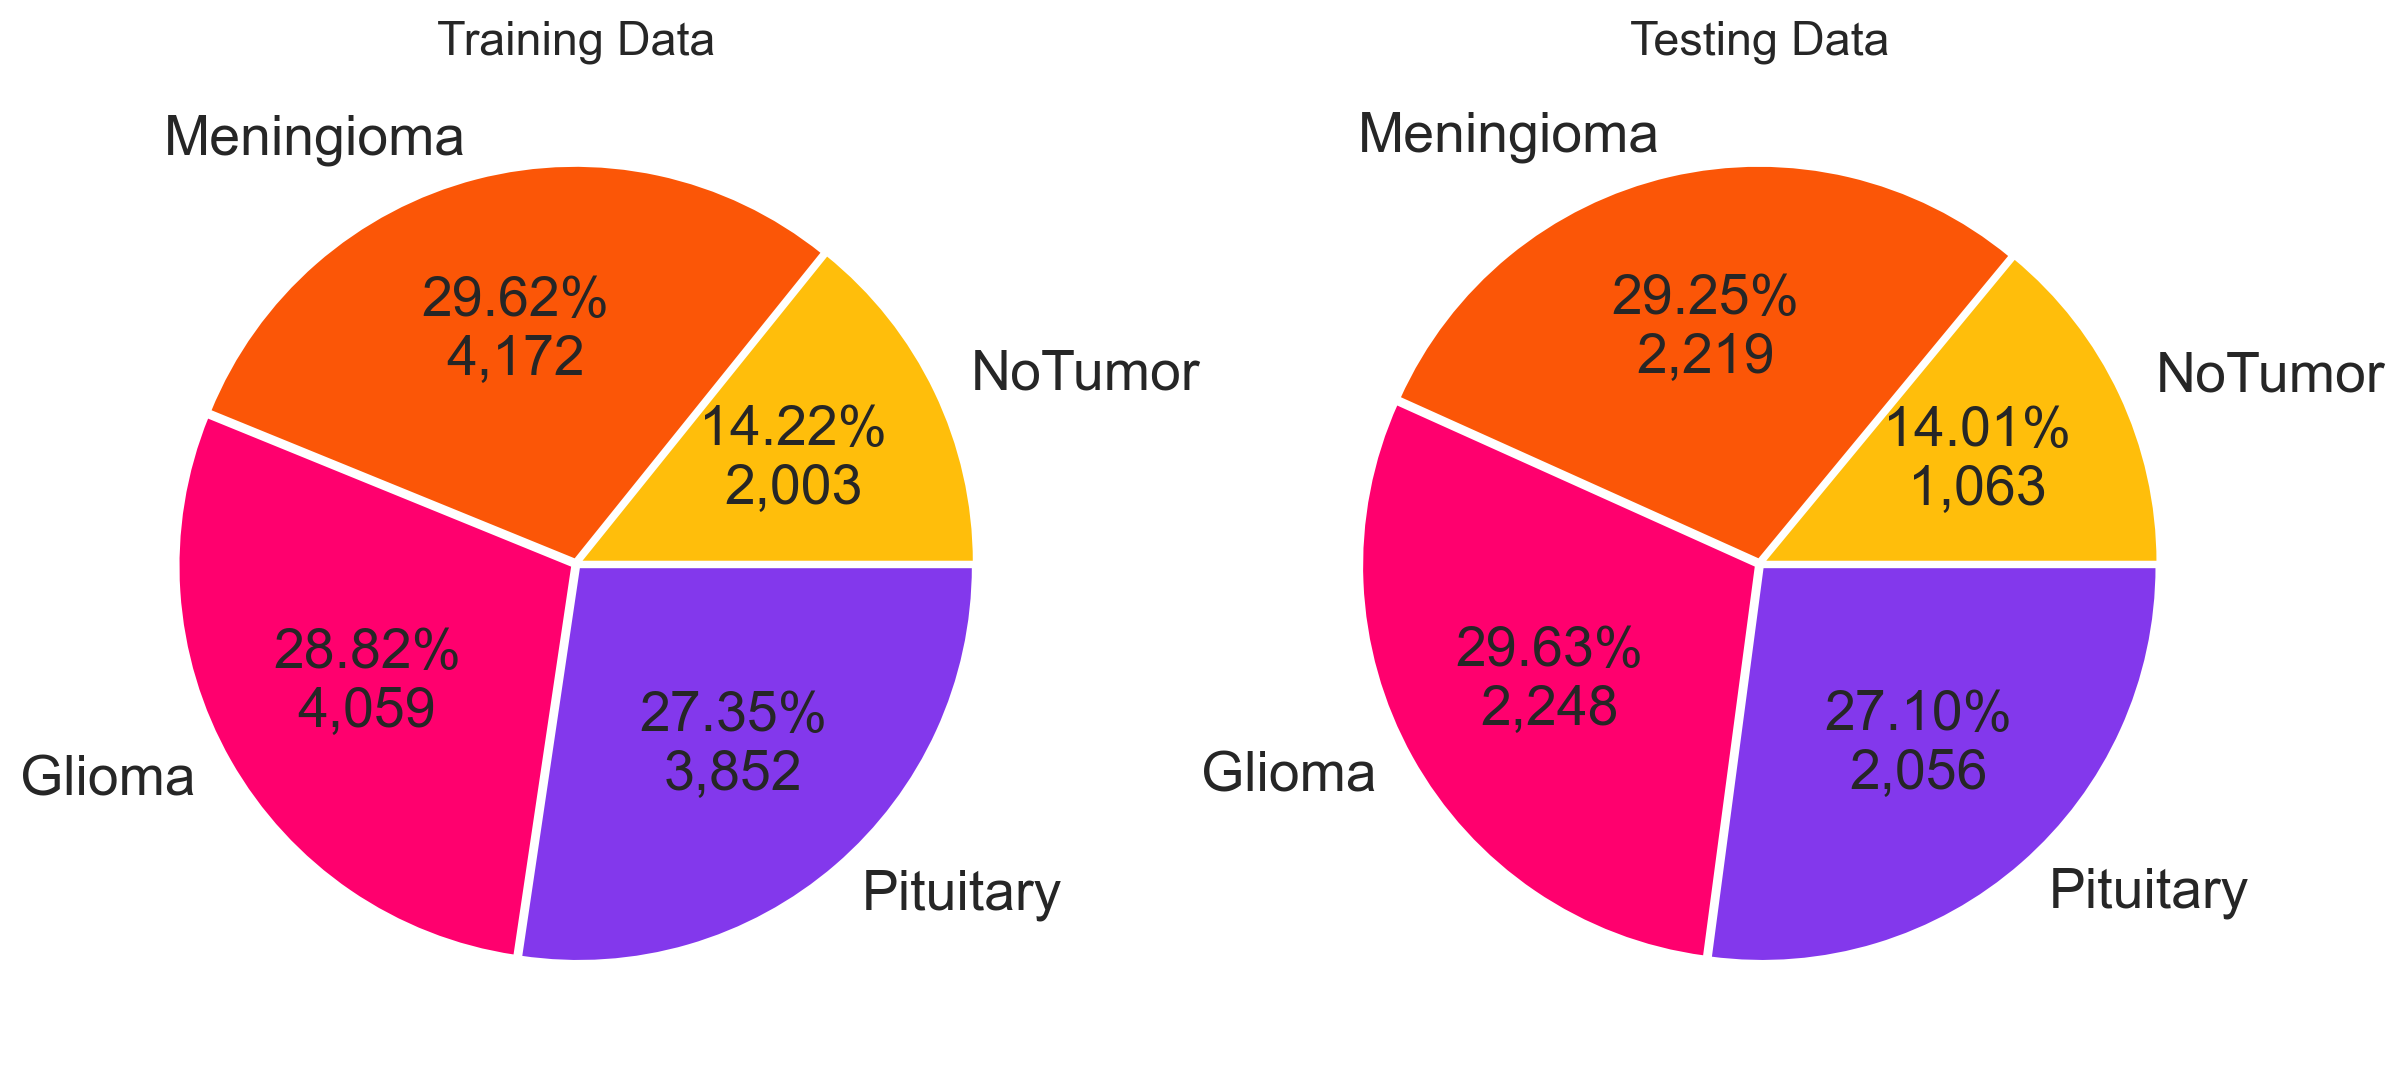

In [14]:
import pandas as pd
import matplotlib.pyplot as plt

TUMOR_TYPES = pd.unique(training_images['label'])
N_TYPES = len(TUMOR_TYPES)

_, ax = plt.subplots(ncols=2, figsize=(14, 7))  # Adjusted to two columns instead of three.

# Plotting training data types
class_counts_train = [len([x for x in train_labels if x == label]) for label in TUMOR_TYPES]
print('Training Counts')
print(dict(zip(TUMOR_TYPES, class_counts_train)))

ax[0].set_title('Training Data')
ax[0].pie(
    class_counts_train,
    labels=TUMOR_TYPES,
    colors=['#FFBE0B','#FB5607', '#FF006E','#8338EC'], 
    autopct=lambda p: '{:.2f}%\n{:,.0f}'.format(p, p * sum(class_counts_train) / 100),
    explode=tuple(0.01 for i in range(N_TYPES)),
    textprops={'fontsize': 20}
)

# Plotting testing data types
class_counts_test = [len([x for x in test_labels if x == label]) for label in TUMOR_TYPES]
print('\nTesting Counts')
print(dict(zip(TUMOR_TYPES, class_counts_test)))

ax[1].set_title('Testing Data')
ax[1].pie(
    class_counts_test,
    labels=TUMOR_TYPES,
    colors=['#FFBE0B','#FB5607', '#FF006E','#8338EC'],
    autopct=lambda p: '{:.2f}%\n{:,.0f}'.format(p, p * sum(class_counts_test) / 100),
    explode=tuple(0.01 for i in range(N_TYPES)),  # Adjusted to dynamically create the explode tuple based on N_TYPES.
    textprops={'fontsize': 20}  # Set the font size for the text on the pie chart
)

plt.show()
